# IMU Data Visualization

- Read data from `../dataset/csv/imu_data.csv` and visualize trajectory using matplotlib
- Remove gravity influence
- Apply Kalman filter for noise reduction
- Visualize linear acceleration, angular velocity, and attitude changes

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.transform import Rotation as R
import os

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Read IMU Data

In [31]:
# Read IMU data
imu_data_path = "../dataset/csv/imu_data.csv"

df = pd.read_csv(imu_data_path)
print(f"Successfully read data, total {len(df)} rows")
df.head()

Successfully read data, total 203912 rows


,timestamp,orientation_x,orientation_y,orientation_z,orientation_w,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,angular_velocity_x,angular_velocity_y,angular_velocity_z
0,1.573567e+09,0.007872,-0.031181,-0.983452,0.178293,0.137485,0.545186,9.704681,0.020420,-0.016096,-0.032753
1,1.573567e+09,0.007861,-0.031201,-0.983464,0.178223,0.026589,0.503092,9.735282,0.018926,-0.015246,-0.038424
2,1.573567e+09,0.007851,-0.031225,-0.983476,0.178151,0.110740,0.586180,9.746132,0.021983,-0.008066,-0.038979
3,1.573567e+09,0.007835,-0.031255,-0.983488,0.178079,0.235584,0.644563,9.730854,0.023340,-0.012474,-0.023375
4,1.573567e+09,0.007822,-0.031276,-0.983498,0.178022,0.094606,0.541219,9.747090,0.022777,-0.010489,-0.023331


## 2. Data Preprocessing

In [32]:
# Data preprocessing

# Calculate time intervals
df['dt'] = df['timestamp'].diff().fillna(0)
print(f"\nTime interval statistics (seconds):")
print(f"Average: {df['dt'].mean():.6f}")
print(f"Minimum: {df['dt'].min():.6f}")
print(f"Maximum: {df['dt'].max():.6f}")

# Extract data
timestamps = df['timestamp'].values
dt = df['dt'].values

# Quaternions
q = np.column_stack([df['orientation_x'], df['orientation_y'], df['orientation_z'], df['orientation_w']])

# Linear acceleration (raw data)
acc_raw = np.column_stack([df['linear_acceleration_x'], df['linear_acceleration_y'], df['linear_acceleration_z']])

# Angular velocity
gyro = np.column_stack([df['angular_velocity_x'], df['angular_velocity_y'], df['angular_velocity_z']])

print("\nData extraction completed!")



Time interval statistics (seconds):
Average: 0.002000
Minimum: 0.000000
Maximum: 0.054956

Data extraction completed!


## 3. Remove Gravity Influence

In [33]:
def remove_gravity(acc_raw, q, gravity_magnitude=9.81):
    """
    Remove gravity influence from linear acceleration
    
    Parameters:
    acc_raw: Raw linear acceleration (N x 3)
    q: Quaternions (N x 4)
    gravity_magnitude: Gravity acceleration magnitude
    
    Returns:
    acc_body: Acceleration after removing gravity (N x 3)
    """
    N = len(acc_raw)
    acc_body = np.zeros_like(acc_raw)
    acc_world = np.zeros_like(acc_raw)
    
    for i in range(N):
        # Create rotation object
        r = R.from_quat(q[i])
        
        # Gravity in world coordinate system
        gravity_world = np.array([0, 0, gravity_magnitude])
        
        # Gravity in IMU coordinate system
        gravity_body = r.inv().apply(gravity_world)
        
        # Remove gravity
        acc_body[i] = acc_raw[i] - gravity_body
    
    return acc_body

# Remove gravity
if 'acc_raw' in locals():
    acc_body = remove_gravity(acc_raw, q)
    
    print("Gravity removal completed!")
    print(f"Raw acceleration range: x[{acc_raw[:,0].min():.3f}, {acc_raw[:,0].max():.3f}], "
          f"y[{acc_raw[:,1].min():.3f}, {acc_raw[:,1].max():.3f}], "
          f"z[{acc_raw[:,2].min():.3f}, {acc_raw[:,2].max():.3f}]")
    print(f"After gravity removal range: x[{acc_body[:,0].min():.3f}, {acc_body[:,0].max():.3f}], "
          f"y[{acc_body[:,1].min():.3f}, {acc_body[:,1].max():.3f}], "
          f"z[{acc_body[:,2].min():.3f}, {acc_body[:,2].max():.3f}]")
else:
    print("Please run the data preprocessing code first")

Gravity removal completed!
Raw acceleration range: x[-7.974, 6.140], y[-5.131, 5.539], z[5.347, 13.857]
After gravity removal range: x[-4.076, 3.920], y[-2.261, 2.546], z[-4.196, 4.306]


## 4. Integrate Position and Velocity

In [34]:
def integrate_imu_data(acc, gyro, dt):
    """
    通过积分计算位置和速度
    
    参数:
    acc: 加速度
    gyro: 角速度
    dt: 时间间隔
    
    返回:
    position: 位置 (world)
    velocity: 速度 (world)
    """
    N = len(acc)
    
    # 初始化
    position = np.zeros((N, 3))
    velocity = np.zeros((N, 3))
    orientation = np.zeros((N, 4))
    
    # 初始状态
    vel = np.zeros(3)
    pos = np.zeros(3)
    # 初始方向 (单位四元数)
    current_rot = R.identity()
    orientation[0] = current_rot.as_quat()  # [x, y, z, w] 顺序
    
    for i in range(1, N):
        cur_acc_body = acc[i].copy()
        rotation_matrix = current_rot.as_matrix()
        cur_acc_world = rotation_matrix @ cur_acc_body
            
        # 1. 更新方向 (使用角速度积分)
        omega = gyro[i]
        angle = np.linalg.norm(omega) * dt
        
        if angle > 1e-10:  # 避免除以零
            axis = omega / angle
            delta_rot = R.from_rotvec(axis * angle)
            current_rot = current_rot * delta_rot
        # 保存当前方向
        orientation[i] = current_rot.as_quat()
        
        # 2. 更新速度和位置 (使用世界坐标系加速度)
        vel += cur_acc_world * dt
        pos += vel * dt
        
        # 保存结果
        velocity[i] = vel
        position[i] = pos
    
    return position, velocity, orientation

# 积分计算
if 'acc_body' in locals():
    position, velocity, orientation = integrate_imu_data(acc_body, gyro, df['dt'].mean())
    
    print("积分计算完成!")
    print(f"最终位置: x={position[-1,0]:.3f}, y={position[-1,1]:.3f}, z={position[-1,2]:.3f}")
    print(f"最大速度: x={np.max(np.abs(velocity[:,0])):.3f}, y={np.max(np.abs(velocity[:,1])):.3f}, z={np.max(np.abs(velocity[:,2])):.3f}")
else:
    print("请先运行重力去除代码")

积分计算完成!
最终位置: x=-618.435, y=254.114, z=-81.737
最大速度: x=4.114, y=4.658, z=3.393


## 4.5. Kalman Filter

In [35]:
# Import Kalman filter module
import sys
sys.path.insert(0, '.')
from imu_kalman_filter import IMUKalmanFilter, compute_noise_reduction_metrics, integrate_imu_data as kalman_integrate

print("Kalman filter module imported successfully!")

Kalman filter module imported successfully!


In [36]:
# Initialize Kalman filter
# Calculate average dt for filter initialization
if 'dt' in locals():
    avg_dt = np.mean(dt[dt > 0])  # Use average of positive dt values
    print(f"Average time step for Kalman filter: {avg_dt:.6f} s")
    
    # Initialize Kalman filter with appropriate parameters
    kf = IMUKalmanFilter(
        dt=avg_dt,
        process_noise_pos=1e-3,
        process_noise_vel=1e-2,
        process_noise_acc_bias=1e-4,
        process_noise_gyro_bias=1e-4,
        meas_noise_acc=0.1,
        meas_noise_gyro=0.01
    )
    
    print("Kalman filter initialized!")
else:
    print("Please run the data preprocessing code first")

Average time step for Kalman filter: 0.018755 s
Kalman filter initialized!


In [37]:
# Apply Kalman filter to IMU data
if 'acc_body' in locals() and 'gyro' in locals():
    print("Starting Kalman filtering...")
    
    # Apply Kalman filter batch processing
    filter_result = kf.filter_batch(acc_body, gyro, timestamps)
    
    # Extract filtered data
    position_filtered = filter_result['position']
    velocity_filtered = filter_result['velocity']
    orientation_filtered = filter_result['orientation']
    acc_filtered = filter_result['acceleration']
    gyro_filtered = filter_result['gyroscope']
    
    print("Kalman filtering completed!")
    print(f"\nFiltered position - Final: x={position_filtered[-1,0]:.3f}, y={position_filtered[-1,1]:.3f}, z={position_filtered[-1,2]:.3f}")
    print(f"Filtered velocity - Max: x={np.max(np.abs(velocity_filtered[:,0])):.3f}, y={np.max(np.abs(velocity_filtered[:,1])):.3f}, z={np.max(np.abs(velocity_filtered[:,2])):.3f}")
else:
    print("Please run the gravity removal and integration code first")

Starting Kalman filtering...


Kalman filtering completed!

Filtered position - Final: x=-259.220, y=104.493, z=-10.582
Filtered velocity - Max: x=1.474, y=1.064, z=2.088


In [38]:
# Compute noise reduction metrics
if 'acc_filtered' in locals():
    print("=== Noise Reduction Metrics ===")
    print()
    
    # Acceleration noise reduction
    acc_metrics = compute_noise_reduction_metrics(acc_body, acc_filtered)
    print("Acceleration (m/s²):")
    print(f"  X-axis: Std raw={acc_metrics['std_raw'][0]:.4f}, Std filtered={acc_metrics['std_filtered'][0]:.4f}, Reduction={acc_metrics['std_reduction_pct'][0]:.1f}%")
    print(f"  Y-axis: Std raw={acc_metrics['std_raw'][1]:.4f}, Std filtered={acc_metrics['std_filtered'][1]:.4f}, Reduction={acc_metrics['std_reduction_pct'][1]:.1f}%")
    print(f"  Z-axis: Std raw={acc_metrics['std_raw'][2]:.4f}, Std filtered={acc_metrics['std_filtered'][2]:.4f}, Reduction={acc_metrics['std_reduction_pct'][2]:.1f}%")
    print()
    
    # Gyroscope noise reduction
    gyro_metrics = compute_noise_reduction_metrics(gyro, gyro_filtered)
    print("Angular Velocity (rad/s):")
    print(f"  X-axis: Std raw={gyro_metrics['std_raw'][0]:.4f}, Std filtered={gyro_metrics['std_filtered'][0]:.4f}, Reduction={gyro_metrics['std_reduction_pct'][0]:.1f}%")
    print(f"  Y-axis: Std raw={gyro_metrics['std_raw'][1]:.4f}, Std filtered={gyro_metrics['std_filtered'][1]:.4f}, Reduction={gyro_metrics['std_reduction_pct'][1]:.1f}%")
    print(f"  Z-axis: Std raw={gyro_metrics['std_raw'][2]:.4f}, Std filtered={gyro_metrics['std_filtered'][2]:.4f}, Reduction={gyro_metrics['std_reduction_pct'][2]:.1f}%")
    print()
    
    # Smoothness improvement
    print("Smoothness Improvement:")
    print(f"  Acceleration: {np.mean(acc_metrics['smoothness_improvement_pct']):.1f}%")
    print(f"  Gyroscope: {np.mean(gyro_metrics['smoothness_improvement_pct']):.1f}%")
else:
    print("Please run the Kalman filtering code first")

=== Noise Reduction Metrics ===

Acceleration (m/s²):
  X-axis: Std raw=0.9214, Std filtered=0.6675, Reduction=27.6%
  Y-axis: Std raw=0.5713, Std filtered=0.3492, Reduction=38.9%
  Z-axis: Std raw=1.6874, Std filtered=0.9966, Reduction=40.9%

Angular Velocity (rad/s):
  X-axis: Std raw=0.2281, Std filtered=0.0769, Reduction=66.3%
  Y-axis: Std raw=0.2627, Std filtered=0.0984, Reduction=62.5%
  Z-axis: Std raw=0.3703, Std filtered=0.0999, Reduction=73.0%

Smoothness Improvement:
  Acceleration: 8.8%
  Gyroscope: 36.3%


## 5. Visualization Results

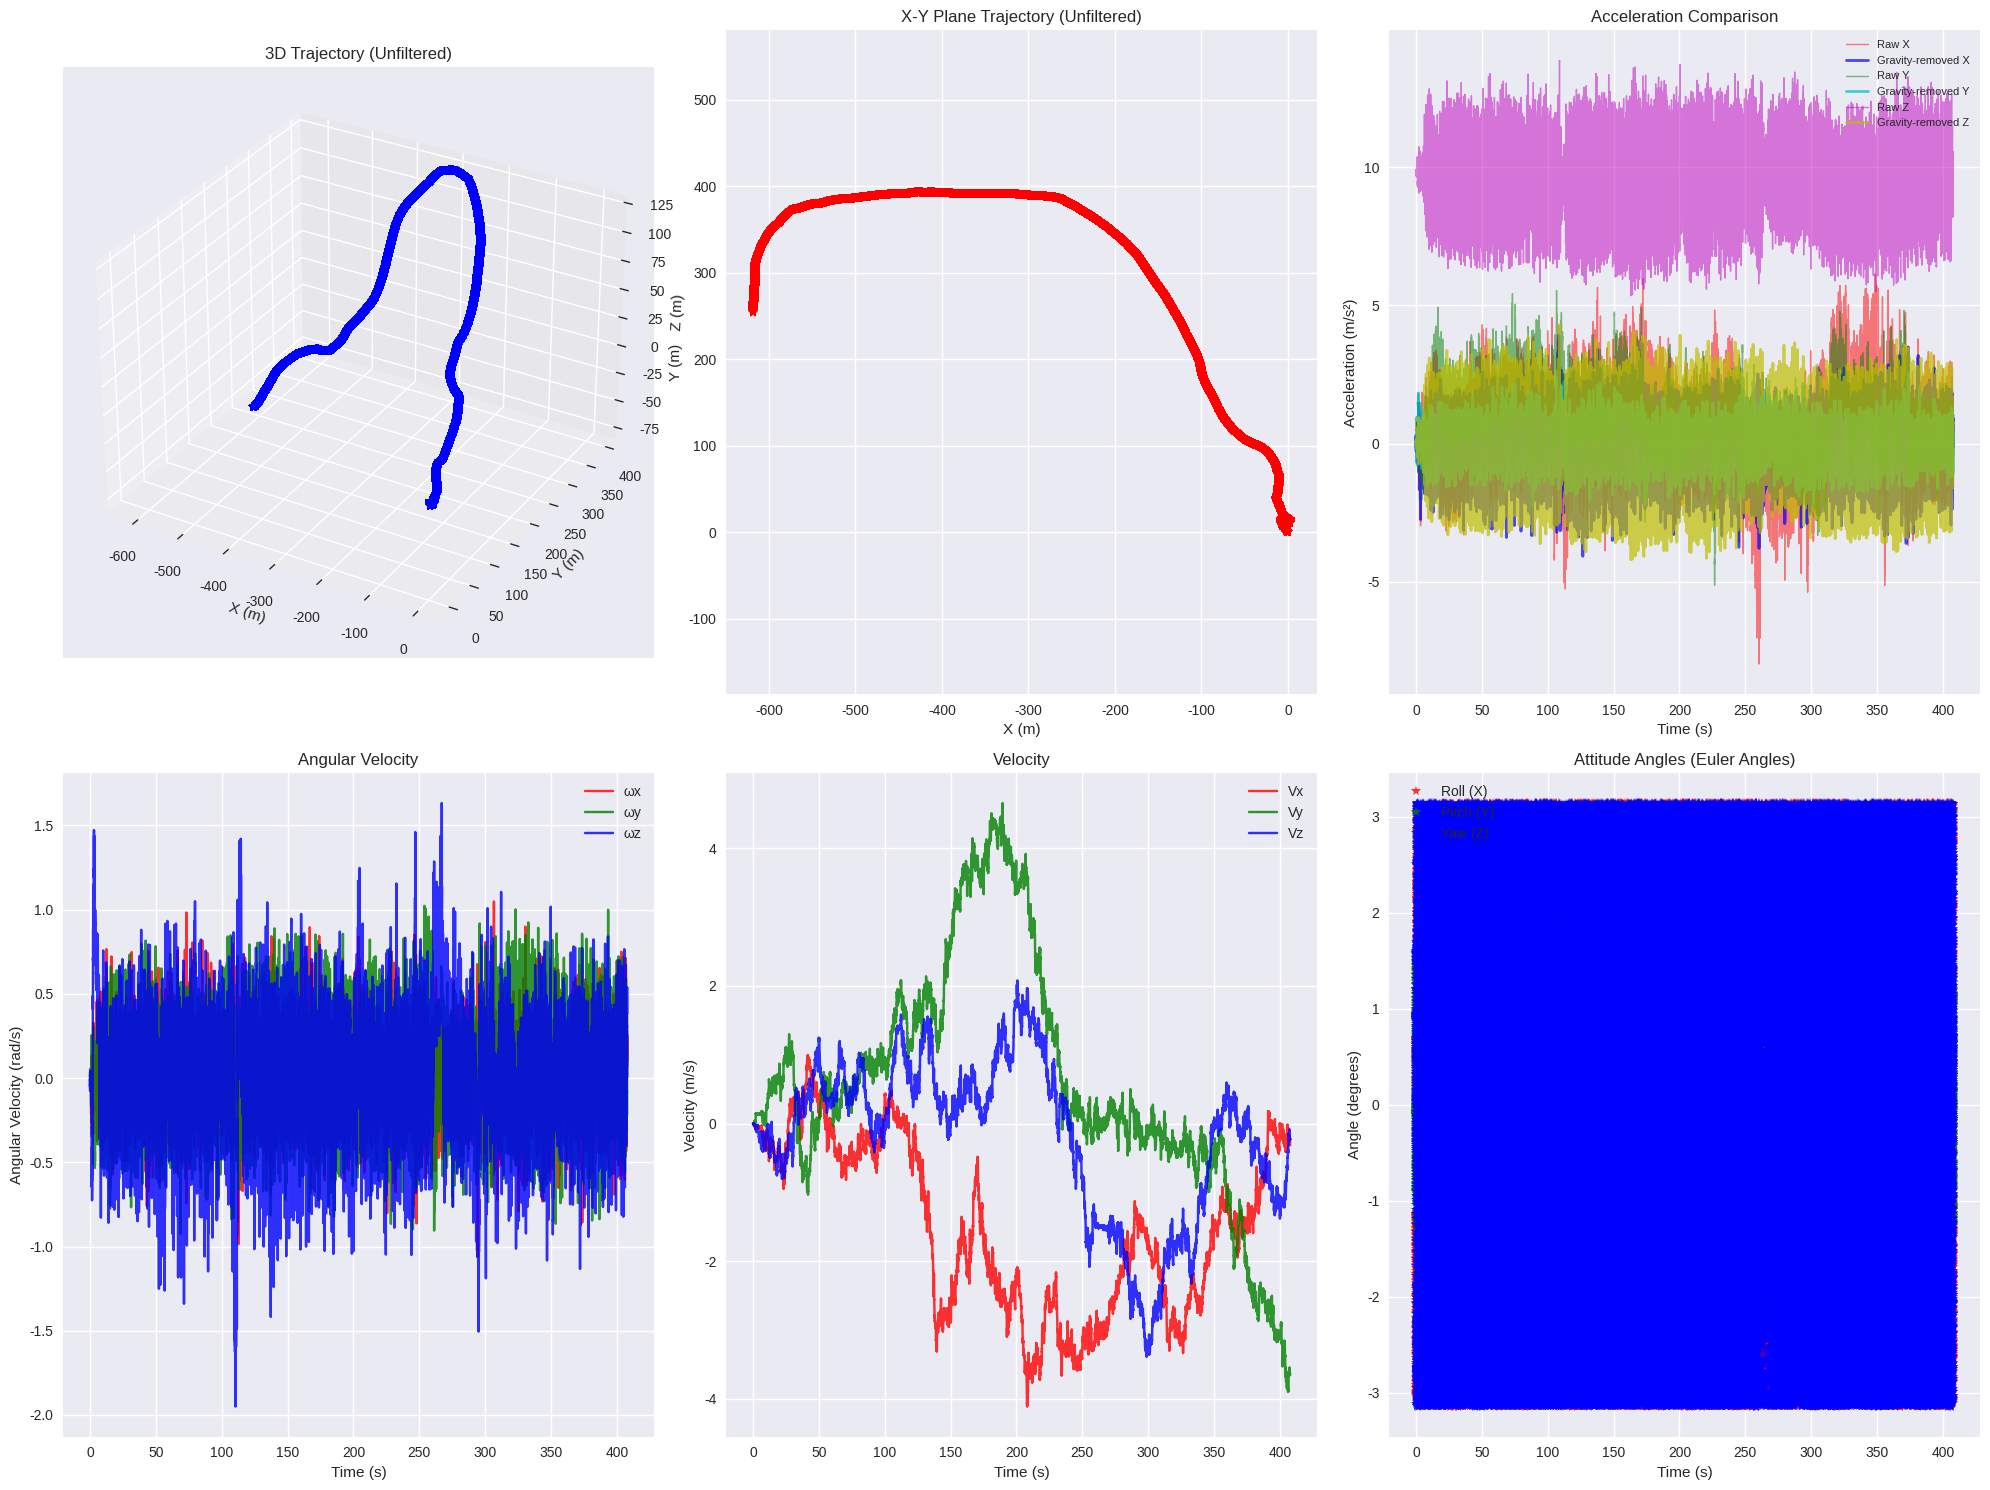

Visualization completed!


In [39]:
# Create visualization charts
if 'position' in locals():
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 3D trajectory
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot(position[:, 0], position[:, 1], position[:, 2], 'b*', linewidth=2, alpha=0.8, label='Unfiltered')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Trajectory (Unfiltered)')
    ax1.grid(True)
    
    # 2. X-Y plane trajectory
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(position[:, 0], position[:, 1], 'r*', linewidth=2, alpha=0.8, label='Unfiltered')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('X-Y Plane Trajectory (Unfiltered)')
    ax2.grid(True)
    ax2.axis('equal')
    
    # 3. Acceleration comparison
    ax3 = fig.add_subplot(2, 3, 3)
    time_sec = timestamps - timestamps[0]
    ax3.plot(time_sec, acc_raw[:, 0], 'r-', label='Raw X', alpha=0.5, linewidth=1)
    ax3.plot(time_sec, acc_body[:, 0], 'b-', label='Gravity-removed X', alpha=0.7, linewidth=2)
    ax3.plot(time_sec, acc_raw[:, 1], 'g-', label='Raw Y', alpha=0.5, linewidth=1)
    ax3.plot(time_sec, acc_body[:, 1], 'c-', label='Gravity-removed Y', alpha=0.7, linewidth=2)
    ax3.plot(time_sec, acc_raw[:, 2], 'm-', label='Raw Z', alpha=0.5, linewidth=1)
    ax3.plot(time_sec, acc_body[:, 2], 'y-', label='Gravity-removed Z', alpha=0.7, linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.set_title('Acceleration Comparison')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True)
    
    # 4. Angular velocity
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.plot(time_sec, gyro[:, 0], 'r-', label='ωx', alpha=0.8)
    ax4.plot(time_sec, gyro[:, 1], 'g-', label='ωy', alpha=0.8)
    ax4.plot(time_sec, gyro[:, 2], 'b-', label='ωz', alpha=0.8)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Angular Velocity (rad/s)')
    ax4.set_title('Angular Velocity')
    ax4.legend()
    ax4.grid(True)
    
    # 5. Velocity
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.plot(time_sec, velocity[:, 0], 'r-', label='Vx', alpha=0.8)
    ax5.plot(time_sec, velocity[:, 1], 'g-', label='Vy', alpha=0.8)
    ax5.plot(time_sec, velocity[:, 2], 'b-', label='Vz', alpha=0.8)
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Velocity (m/s)')
    ax5.set_title('Velocity')
    ax5.legend()
    ax5.grid(True)
    
    # 6. Attitude angles (Euler angles)
    ax6 = fig.add_subplot(2, 3, 6)
    
    # Convert quaternions to Euler angles, handling zero norm issues
    def safe_quat_to_euler(quats):
        euler_angles = np.zeros((len(quats), 3))
        for i, q in enumerate(quats):
            if np.linalg.norm(q) < 1e-6:  # 检测零范数
                euler_angles[i] = euler_angles[i-1]  # 设为默认值
            else:
                try:
                    euler_angles[i] = R.from_quat(q).as_euler('xyz')
                except Exception as e:
                    print(q)
        return euler_angles
    
    euler = safe_quat_to_euler(orientation)
    
    ax6.plot(time_sec, euler[:, 0], 'r*', label='Roll (X)', alpha=0.8)
    ax6.plot(time_sec, euler[:, 1], 'g*', label='Pitch (Y)', alpha=0.8)
    ax6.plot(time_sec, euler[:, 2], 'b*', label='Yaw (Z)', alpha=0.8)
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Angle (degrees)')
    ax6.set_title('Attitude Angles (Euler Angles)')
    ax6.legend()
    ax6.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization completed!")
else:
    print("Please run the integration calculation code first")

## 5.5. Filtered Data Visualization

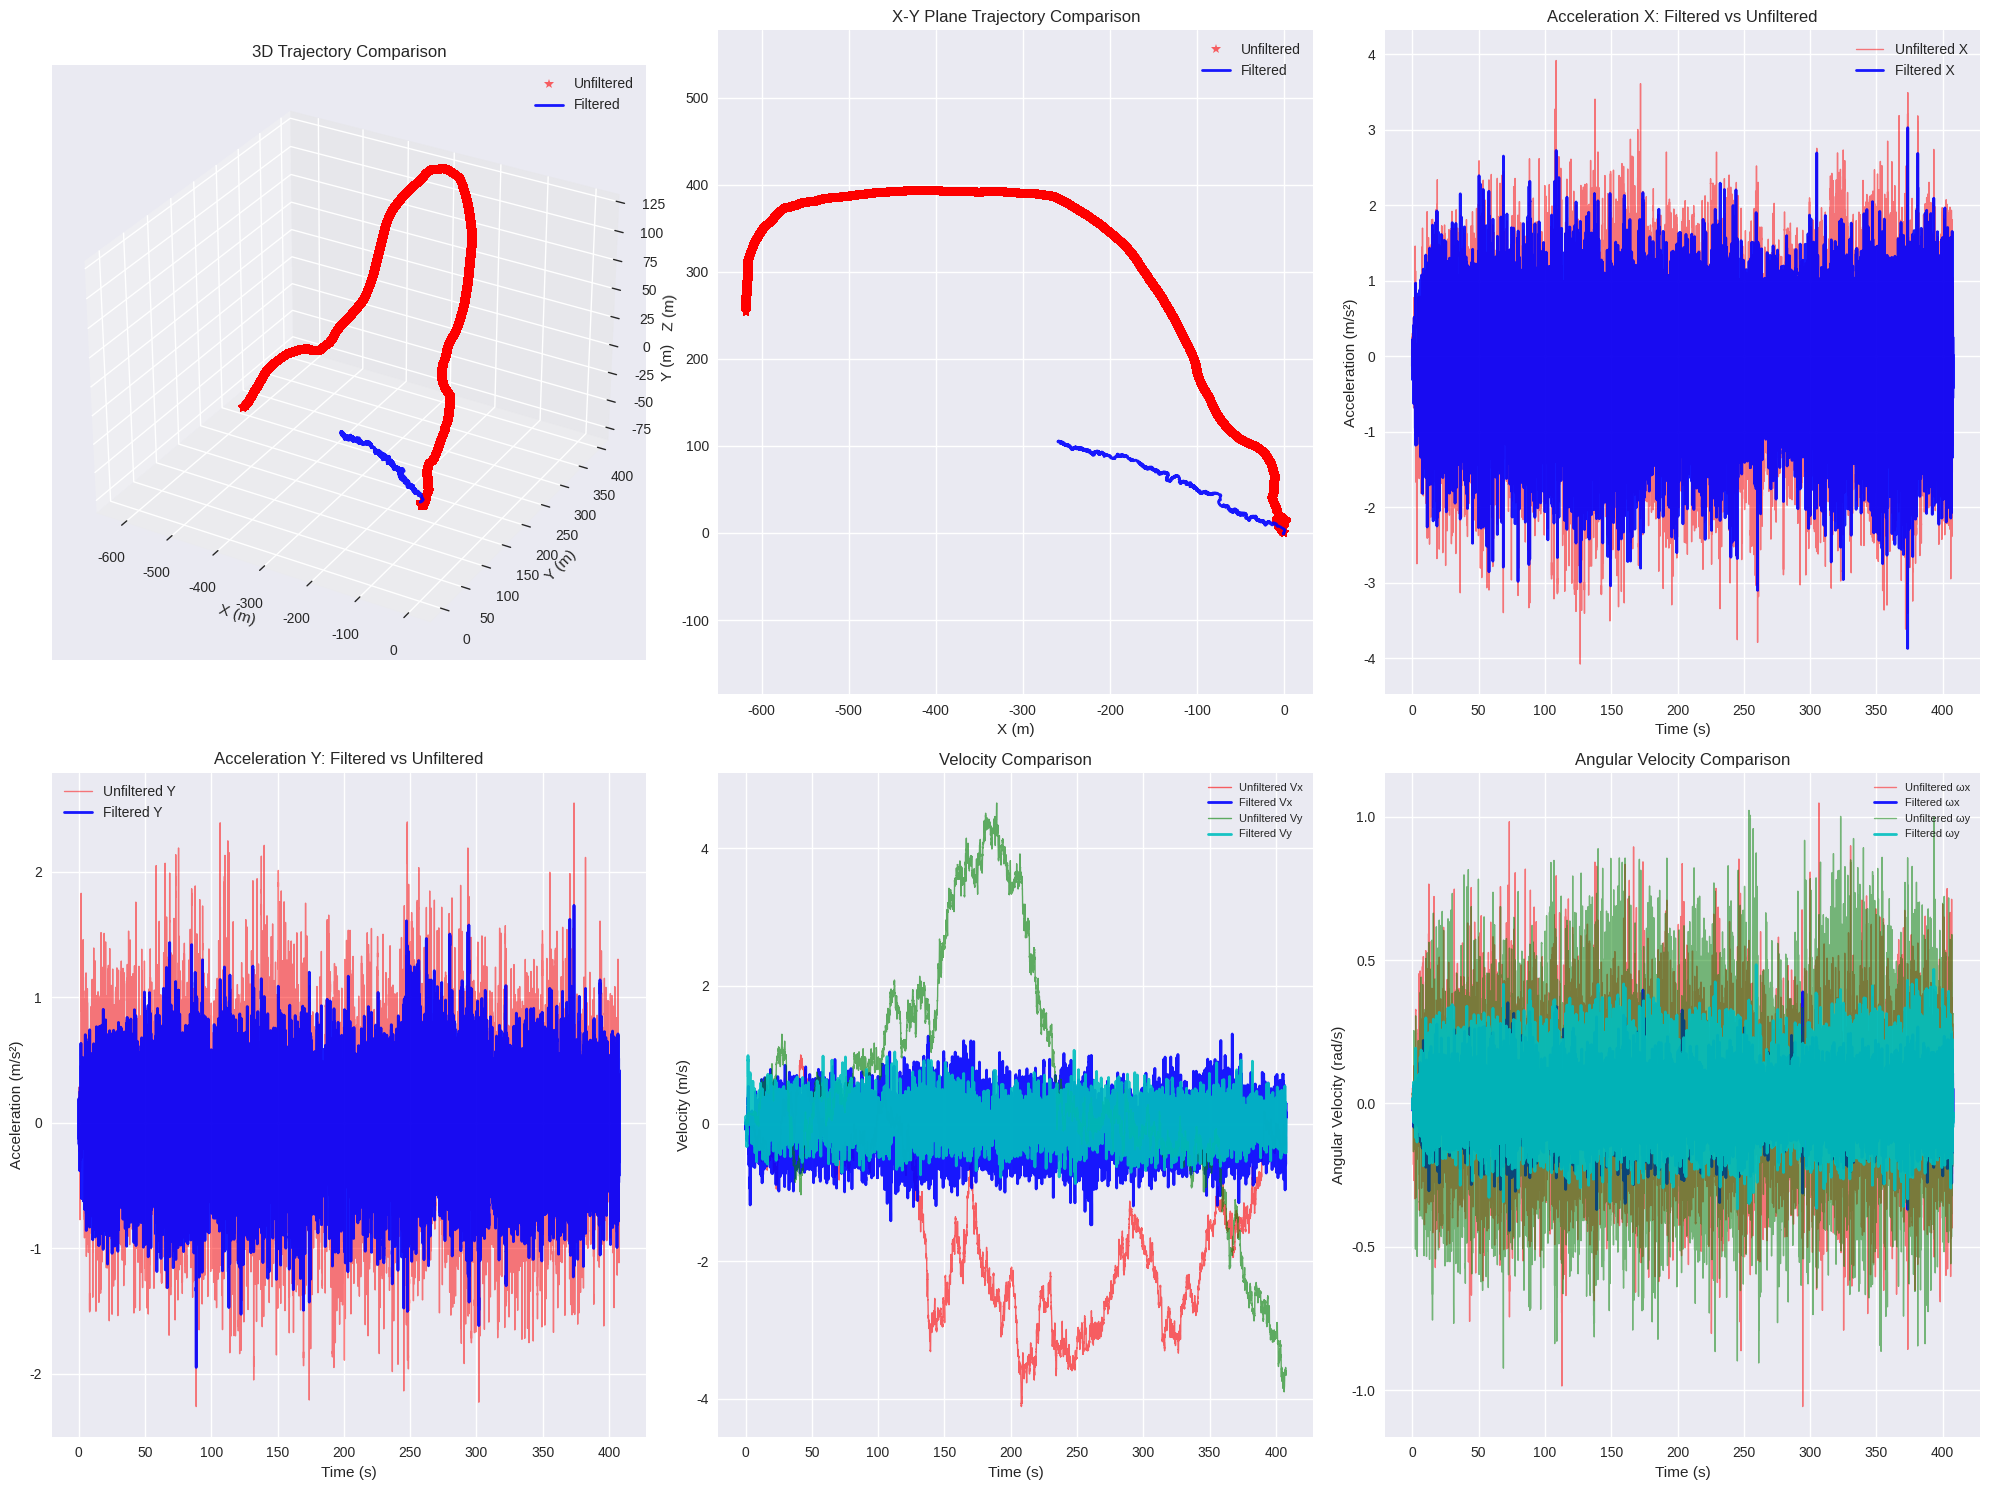

Filtered data visualization completed!


In [40]:
# Create filtered data visualization
if 'position_filtered' in locals():
    fig_filtered = plt.figure(figsize=(20, 15))
    
    # 1. 3D trajectory comparison
    ax1 = fig_filtered.add_subplot(2, 3, 1, projection='3d')
    ax1.plot(position[:, 0], position[:, 1], position[:, 2], 'r*', linewidth=1, alpha=0.6, label='Unfiltered')
    ax1.plot(position_filtered[:, 0], position_filtered[:, 1], position_filtered[:, 2], 'b-', linewidth=2, alpha=0.9, label='Filtered')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Trajectory Comparison')
    ax1.legend()
    ax1.grid(True)
    
    # 2. X-Y plane trajectory comparison
    ax2 = fig_filtered.add_subplot(2, 3, 2)
    ax2.plot(position[:, 0], position[:, 1], 'r*', linewidth=1, alpha=0.6, label='Unfiltered')
    ax2.plot(position_filtered[:, 0], position_filtered[:, 1], 'b-', linewidth=2, alpha=0.9, label='Filtered')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('X-Y Plane Trajectory Comparison')
    ax2.legend()
    ax2.grid(True)
    ax2.axis('equal')
    
    # 3. Acceleration filtering comparison (X-axis)
    ax3 = fig_filtered.add_subplot(2, 3, 3)
    time_sec = timestamps - timestamps[0]
    ax3.plot(time_sec, acc_body[:, 0], 'r-', label='Unfiltered X', alpha=0.5, linewidth=1)
    ax3.plot(time_sec, acc_filtered[:, 0], 'b-', label='Filtered X', alpha=0.9, linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.set_title('Acceleration X: Filtered vs Unfiltered')
    ax3.legend()
    ax3.grid(True)
    
    # 4. Acceleration filtering comparison (Y-axis)
    ax4 = fig_filtered.add_subplot(2, 3, 4)
    ax4.plot(time_sec, acc_body[:, 1], 'r-', label='Unfiltered Y', alpha=0.5, linewidth=1)
    ax4.plot(time_sec, acc_filtered[:, 1], 'b-', label='Filtered Y', alpha=0.9, linewidth=2)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Acceleration (m/s²)')
    ax4.set_title('Acceleration Y: Filtered vs Unfiltered')
    ax4.legend()
    ax4.grid(True)
    
    # 5. Velocity comparison
    ax5 = fig_filtered.add_subplot(2, 3, 5)
    ax5.plot(time_sec, velocity[:, 0], 'r-', label='Unfiltered Vx', alpha=0.6, linewidth=1)
    ax5.plot(time_sec, velocity_filtered[:, 0], 'b-', label='Filtered Vx', alpha=0.9, linewidth=2)
    ax5.plot(time_sec, velocity[:, 1], 'g-', label='Unfiltered Vy', alpha=0.6, linewidth=1)
    ax5.plot(time_sec, velocity_filtered[:, 1], 'c-', label='Filtered Vy', alpha=0.9, linewidth=2)
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Velocity (m/s)')
    ax5.set_title('Velocity Comparison')
    ax5.legend(loc='upper right', fontsize=8)
    ax5.grid(True)
    
    # 6. Gyroscope filtering comparison
    ax6 = fig_filtered.add_subplot(2, 3, 6)
    ax6.plot(time_sec, gyro[:, 0], 'r-', label='Unfiltered ωx', alpha=0.5, linewidth=1)
    ax6.plot(time_sec, gyro_filtered[:, 0], 'b-', label='Filtered ωx', alpha=0.9, linewidth=2)
    ax6.plot(time_sec, gyro[:, 1], 'g-', label='Unfiltered ωy', alpha=0.5, linewidth=1)
    ax6.plot(time_sec, gyro_filtered[:, 1], 'c-', label='Filtered ωy', alpha=0.9, linewidth=2)
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Angular Velocity (rad/s)')
    ax6.set_title('Angular Velocity Comparison')
    ax6.legend(loc='upper right', fontsize=8)
    ax6.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Filtered data visualization completed!")
else:
    print("Please run the Kalman filtering code first")

## 6. Detailed Statistical Analysis

In [41]:
# Statistical analysis
if 'position' in locals():
    print("=== IMU Data Statistical Analysis ===")
    print()
    
    # Trajectory statistics
    total_distance = np.sum(np.sqrt(np.sum(np.diff(position, axis=0)**2, axis=1)))
    max_height = np.max(position[:, 2])
    min_height = np.min(position[:, 2])
    
    print(f"Total trajectory length: {total_distance:.3f} m")
    print(f"Maximum height: {max_height:.3f} m")
    print(f"Minimum height: {min_height:.3f} m")
    print(f"Height variation: {max_height - min_height:.3f} m")
    print()
    
    # Acceleration statistics
    print("Acceleration statistics (after gravity removal):")
    print(f"X-axis: Mean={np.mean(acc_body[:,0]):.3f}, Std={np.std(acc_body[:,0]):.3f}, Range=[{np.min(acc_body[:,0]):.3f}, {np.max(acc_body[:,0]):.3f}]")
    print(f"Y-axis: Mean={np.mean(acc_body[:,1]):.3f}, Std={np.std(acc_body[:,1]):.3f}, Range=[{np.min(acc_body[:,1]):.3f}, {np.max(acc_body[:,1]):.3f}]")
    print(f"Z-axis: Mean={np.mean(acc_body[:,2]):.3f}, Std={np.std(acc_body[:,2]):.3f}, Range=[{np.min(acc_body[:,2]):.3f}, {np.max(acc_body[:,2]):.3f}]")
    print()
    
    # Angular velocity statistics
    print("Angular velocity statistics:")
    print(f"X-axis: Mean={np.mean(gyro[:,0]):.3f}, Std={np.std(gyro[:,0]):.3f}, Range=[{np.min(gyro[:,0]):.3f}, {np.max(gyro[:,0]):.3f}]")
    print(f"Y-axis: Mean={np.mean(gyro[:,1]):.3f}, Std={np.std(gyro[:,1]):.3f}, Range=[{np.min(gyro[:,1]):.3f}, {np.max(gyro[:,1]):.3f}]")
    print(f"Z-axis: Mean={np.mean(gyro[:,2]):.3f}, Std={np.std(gyro[:,2]):.3f}, Range=[{np.min(gyro[:,2]):.3f}, {np.max(gyro[:,2]):.3f}]")
    print()
    
    # Velocity statistics
    print("Velocity statistics:")
    print(f"X-axis: Mean={np.mean(velocity[:,0]):.3f}, Max={np.max(np.abs(velocity[:,0])):.3f}")
    print(f"Y-axis: Mean={np.mean(velocity[:,1]):.3f}, Max={np.max(np.abs(velocity[:,1])):.3f}")
    print(f"Z-axis: Mean={np.mean(velocity[:,2]):.3f}, Max={np.max(np.abs(velocity[:,2])):.3f}")
    print()
    
    # Time statistics
    total_time = timestamps[-1] - timestamps[0]
    avg_dt = np.mean(dt[1:])  # Exclude first 0
    print(f"Total time: {total_time:.3f} s")
    print(f"Average sampling interval: {avg_dt*1000:.3f} ms")
    print(f"Average sampling frequency: {1/avg_dt:.2f} Hz")
    
else:
    print("Please run the integration calculation code first")

=== IMU Data Statistical Analysis ===

Total trajectory length: 1072.536 m
Maximum height: 127.057 m
Minimum height: -81.737 m
Height variation: 208.794 m

Acceleration statistics (after gravity removal):
X-axis: Mean=0.004, Std=0.921, Range=[-4.076, 3.920]
Y-axis: Mean=-0.003, Std=0.571, Range=[-2.261, 2.546]
Z-axis: Mean=-0.012, Std=1.687, Range=[-4.196, 4.306]

Angular velocity statistics:
X-axis: Mean=-0.003, Std=0.228, Range=[-1.057, 1.048]
Y-axis: Mean=-0.002, Std=0.263, Range=[-0.923, 1.022]
Z-axis: Mean=0.000, Std=0.370, Range=[-1.950, 1.632]

Velocity statistics:
X-axis: Mean=-1.517, Max=4.114
Y-axis: Mean=0.623, Max=4.658
Z-axis: Mean=-0.200, Max=3.393

Total time: 407.779 s
Average sampling interval: 2.000 ms
Average sampling frequency: 500.05 Hz


## 7. Save Results

In [42]:
# Save processed data
if 'position' in locals():
    # Create output directory
    output_dir = "../dataset/visualization_results"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save processed data
    processed_data = {
        'timestamp': timestamps,
        'dt': dt,
        'pos_x': position[:, 0],
        'pos_y': position[:, 1],
        'pos_z': position[:, 2],
        'vel_x': velocity[:, 0],
        'vel_y': velocity[:, 1],
        'vel_z': velocity[:, 2],
        'acc_body_x': acc_body[:, 0],
        'acc_body_y': acc_body[:, 1],
        'acc_body_z': acc_body[:, 2],
        'acc_world_x': acc_world[:, 0],
        'acc_world_y': acc_world[:, 1],
        'acc_world_z': acc_world[:, 2],
        'gyro_x': gyro[:, 0],
        'gyro_y': gyro[:, 1],
        'gyro_z': gyro[:, 2],
        'q_w': orientation[:, 3],
        'q_x': orientation[:, 0],
        'q_y': orientation[:, 1],
        'q_z': orientation[:, 2],
    }
    
    df_processed = pd.DataFrame(processed_data)
    output_file = os.path.join(output_dir, "imu_processed_data.csv")
    df_processed.to_csv(output_file, index=False)
    
    # Save visualization image
    fig.savefig(os.path.join(output_dir, "imu_visualization.png"), dpi=300, bbox_inches='tight')
    
    print(f"Processed data saved to: {output_file}")
    print(f"Visualization image saved to: {output_dir}/imu_visualization.png")
    
    # Save filtered data if available
    if 'position_filtered' in locals():
        filtered_data = {
            'timestamp': timestamps,
            'dt': dt,
            'pos_x_filtered': position_filtered[:, 0],
            'pos_y_filtered': position_filtered[:, 1],
            'pos_z_filtered': position_filtered[:, 2],
            'vel_x_filtered': velocity_filtered[:, 0],
            'vel_y_filtered': velocity_filtered[:, 1],
            'vel_z_filtered': velocity_filtered[:, 2],
            'acc_x_filtered': acc_filtered[:, 0],
            'acc_y_filtered': acc_filtered[:, 1],
            'acc_z_filtered': acc_filtered[:, 2],
            'gyro_x_filtered': gyro_filtered[:, 0],
            'gyro_y_filtered': gyro_filtered[:, 1],
            'gyro_z_filtered': gyro_filtered[:, 2],
            'q_w_filtered': orientation_filtered[:, 3],
            'q_x_filtered': orientation_filtered[:, 0],
            'q_y_filtered': orientation_filtered[:, 1],
            'q_z_filtered': orientation_filtered[:, 2],
        }
        
        df_filtered = pd.DataFrame(filtered_data)
        filtered_file = os.path.join(output_dir, "imu_filtered_data.csv")
        df_filtered.to_csv(filtered_file, index=False)
        
        # Save filtered visualization
        fig_filtered.savefig(os.path.join(output_dir, "imu_filtered_visualization.png"), dpi=300, bbox_inches='tight')
        
        print(f"Filtered data saved to: {filtered_file}")
        print(f"Filtered visualization image saved to: {output_dir}/imu_filtered_visualization.png")
    
else:
    print("Please run the integration calculation code first")

Processed data saved to: ../dataset/visualization_results/imu_processed_data.csv
Visualization image saved to: ../dataset/visualization_results/imu_visualization.png
Filtered data saved to: ../dataset/visualization_results/imu_filtered_data.csv
Filtered visualization image saved to: ../dataset/visualization_results/imu_filtered_visualization.png


## 8. Summary

This Jupyter Notebook implements a complete IMU data visualization workflow:

1. **Data Reading**: Read IMU data from CSV file
2. **Data Preprocessing**: Remove duplicates, sort, calculate time intervals
3. **Gravity Removal**: Use quaternions to separate gravity from linear acceleration
4. **Numerical Integration**: Calculate position, velocity, and attitude changes through integration
5. **Kalman Filtering**: Apply Kalman filter to reduce noise and improve state estimation
6. **Visualization**: Generate 3D trajectory, 2D trajectory, acceleration comparison, angular velocity, velocity, and attitude angle charts (both filtered and unfiltered)
7. **Statistical Analysis**: Provide detailed statistical data
8. **Result Saving**: Save processed data and visualization images

### Key Features:
- Automatic data detection and processing
- Gravity removal to obtain real motion acceleration
- Kalman filtering for noise reduction and state estimation
- Multiple visualization methods to display IMU data
- Comparison between filtered and unfiltered data
- Detailed statistical analysis with noise reduction metrics
- Result file saving for both raw and filtered data